<a href="https://colab.research.google.com/github/pranjalbhawsar11/PruningLSTM-Model/blob/main/final_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q tensorflow-model-optimization

     |████████████████████████████████| 238 kB 5.6 MB/s 


In [ ]:
import tempfile
import zipfile
import os
import h5py
import numpy as np
import glob
import math
from numpy import linalg as LA
from scipy.stats import rankdata
from shutil import copyfile, move
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow_model_optimization.python.core.sparsity.keras import prune
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_schedule
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

keras = tf.keras
K = tf.keras.backend

In [ ]:
%load_ext tensorboard
import tensorboard

In [ ]:
logdir = tempfile.mkdtemp()
print('Writing training logs to ' + logdir)
%tensorboard --logdir={logdir}

In [ ]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]
max_features = 20000
maxlen = 100  # cut texts after this number of words
batch_size = 32

print("Loading data...")
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), "train sequences")
print(len(x_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

print("Build model...")
model = keras.models.Sequential()
model.add(keras.layers.Embedding(max_features, 128, input_length=maxlen))
model.add(keras.layers.LSTM(128))  
model.add(keras.layers.Dense(1))
model.add(keras.layers.Activation("sigmoid"))

model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          verbose=1,
          callbacks=callbacks,
          validation_data=(x_test, y_test))


Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Build model...
Epoch 1/3
782/782 [==============================] - 139s 176ms/step - loss: 0.4201 - accuracy: 0.8036 - val_loss: 0.3801 - val_accuracy: 0.8396
Epoch 2/3
782/782 [==============================] - 137s 175ms/step - loss: 0.2358 - accuracy: 0.9085 - val_loss: 0.3513 - val_accuracy: 0.8452
Epoch 3/3
782/782 [==============================] - 121s 155ms/step - loss: 0.1435 - accuracy: 0.9467 - val_loss: 0.4283 - val_accuracy: 0.8311


In [ ]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

782/782 [==============================] - 32s 40ms/step - loss: 0.4283 - accuracy: 0.8311
Test loss: 0.42827558517456055
Test accuracy: 0.8311200141906738


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


# Save model

In [ ]:
#Save model
_, model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, model_file, include_optimizer=False)

# Weight Pruning

In [ ]:
lay1=[]
def print_attrs(name, obj):
    # Create indent
    shift = name.count('/') * '    '
    item_name = name.split("/")[-1]
    print(shift + item_name)
    try:
        for key, val in obj.attrs.items():
            if(key=='weight_names'):
              lay1.append(val[0])
              print(shift + '    ' + f"{key}: {val}")
    except:
        pass


for k in [0.2,0.3,0.4,0.5,0.7,.80,.84,.88, .92, .94, .98, .99]:
    copyfile(model_file,"/tmp/orig.h5")
    f = h5py.File("/tmp/orig.h5",'r+')
    f.visititems(print_attrs)
    m=0
    for i in list(f.get('model_weights'))[:-1]:
      if(i=="activation" ):
        continue
      elif(i=="dense"):
        m=m+1
        continue
      else:
        data=f['model_weights'][i][lay1[m]]
        w=np.array(data)
        ind = np.unravel_index(np.argsort(w, axis=None), w.shape)
        for i in range(int(len(ind[0])*k)):
          w[ind[0][i]][ind[1][i]]=0
        data[...]=w
        m=m+1
      
    f.close()
    move("/tmp/orig.h5","/tmp/weight_"+str(k)+".h5")


# compilation using pruned **weights**

In [ ]:
files_weights = glob.glob('/tmp/weight_*.h5')
files_weights.sort()
accuracy_weights = []

for f in files_weights:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model.evaluate(x_test, y_test, verbose=1)
  params=0
  accuracy_weights.append(score[1])

782/782 [==============================] - 28s 35ms/step - loss: 0.7391 - accuracy: 0.5000


In [ ]:
accuracy_weights

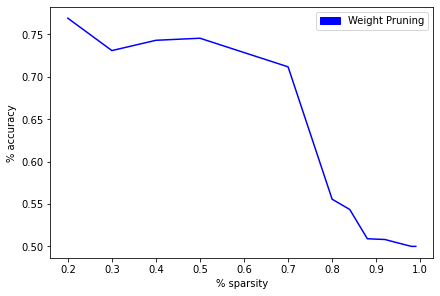

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
#red_patch = mpatches.Patch(color='red', label='Neuron Pruning')
blue_patch = mpatches.Patch(color='blue',label='Weight Pruning')
plt.legend(handles=[blue_patch],loc='upper right')
#plt.plot([.25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_neurons,color='red')
plt.plot([20,30,40,50,70,80,84,88,92,94,98,99],accuracy_weights,color='blue')
plt.show()

**Memory Analysis after weight pruning**

In [ ]:
#for upruned model
memory=[]
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(model_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(model_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))
memory=[]
memory.append((os.path.getsize(zip1) / float(2**20)))

pruned_keras_files = files_weights
for pruned_keras_file in pruned_keras_files:
  _, zip2 = tempfile.mkstemp('.zip') 
  with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
  memory.append((os.path.getsize(zip2) / float(2**20)))
  print("Size of the pruned model before compression: %.2f Mb" % 
    (os.path.getsize(pruned_keras_file) / float(2**20)))
  print("Size of the pruned model after compression: %.2f Mb" % 
    (os.path.getsize(zip2) / float(2**20)))


Size of the unpruned model before compression: 10.29 Mb
Size of the unpruned model after compression: 9.50 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 8.22 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 7.42 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 6.59 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 5.63 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 3.62 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 2.59 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 2.15 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 1.71 Mb
Size of the pruned model before compressio

In [ ]:
print(memory)

[9.504719734191895, 3.133432388305664, 2.7376060485839844, 2.3288793563842773, 1.9019231796264648, 1.6760530471801758, 1.1866645812988281, 1.0518989562988281]


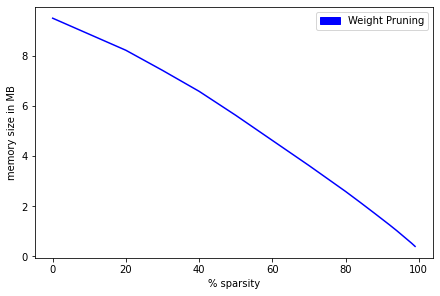

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('memory size in MB')

blue_patch = mpatches.Patch(color='blue',label='Weight Pruning')
plt.legend(handles=[blue_patch],loc='upper right')
#plt.plot([.25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_neurons,color='red')
plt.plot([0,20,30,40,50,70,80,84,88, 92,94,98,99],memory,color='blue')
plt.show()

# **Neuron** **Pruning**

In [ ]:
lay2=[]
def print_attrs(name, obj):
    # Create indent
    shift = name.count('/') * '    '
    item_name = name.split("/")[-1]
    print(shift + item_name)
    try:
        for key, val in obj.attrs.items():
            if(key=='weight_names'):
              lay2.append(val[0])
              print(shift + '    ' + f"{key}: {val}")
    except:
        pass


for k in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,.80]:
    copyfile(model_file,"/tmp/orig.h5")
    f = h5py.File("/tmp/orig.h5",'r+')
    f.visititems(print_attrs)
    m=0
    for i in list(f.get('model_weights'))[:-1]:
      if(i=="activation" ):
        continue
      elif(i=="dense"):
        m=m+1
        continue
      else:
        data=f['model_weights'][i][lay2[m]]
        w=np.array(data)
  
        ind = np.argsort(LA.norm(w, axis=0))
        index_len=int(len(ind)*k)
        for i in range(index_len):
          w[:,ind[i]]=0
        data[...]=w
        m=m+1
      
    f.close()
    move("/tmp/orig.h5","/tmp/neuron_"+str(k)+".h5")


model_weights
    activation
    dense
        weight_names: ['dense/kernel:0' 'dense/bias:0']
        dense
            bias:0
            kernel:0
    embedding
        weight_names: ['embedding/embeddings:0']
        embedding
            embeddings:0
    lstm
        weight_names: ['lstm/lstm_cell/kernel:0' 'lstm/lstm_cell/recurrent_kernel:0'
 'lstm/lstm_cell/bias:0']
        lstm
            lstm_cell
                bias:0
                kernel:0
                recurrent_kernel:0
    top_level_model_weights
model_weights
    activation
    dense
        weight_names: ['dense/kernel:0' 'dense/bias:0']
        dense
            bias:0
            kernel:0
    embedding
        weight_names: ['embedding/embeddings:0']
        embedding
            embeddings:0
    lstm
        weight_names: ['lstm/lstm_cell/kernel:0' 'lstm/lstm_cell/recurrent_kernel:0'
 'lstm/lstm_cell/bias:0']
        lstm
            lstm_cell
                bias:0
                kernel:0
                recur

In [ ]:
files_neurons = glob.glob('/tmp/neuron_*.h5')
files_neurons.sort()
accuracy_neurons = []

for f in files_neurons:
  restored_model_2 = tf.keras.models.load_model(f,compile=False)
  restored_model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model_2.evaluate(x_test, y_test, verbose=1)
  accuracy_neurons.append(score[1])


782/782 [==============================] - 29s 36ms/step - loss: 0.7223 - accuracy: 0.5074


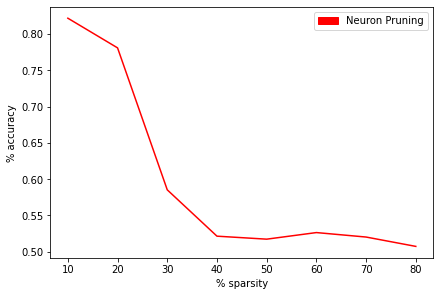

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
red_patch = mpatches.Patch(color='red', label='Neuron Pruning')
plt.legend(handles=[red_patch],loc='upper right')
#plt.plot([.25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_neurons,color='red')
plt.plot([10,20,30,40,50,60,70,80],accuracy_neurons,color='red')
plt.show()

In [ ]:
#for upruned model
memory1=[]
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(model_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(model_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

memory1.append((os.path.getsize(zip1) / float(2**20)))

pruned_files = files_neurons
for pruned_keras_file in pruned_files:
  _, zip2 = tempfile.mkstemp('.zip') 
  with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
  memory.append((os.path.getsize(zip2) / float(2**20)))
  print("Size of the pruned model before compression: %.2f Mb" % 
    (os.path.getsize(pruned_keras_file) / float(2**20)))
  print("Size of the pruned model after compression: %.2f Mb" % 
    (os.path.getsize(zip2) / float(2**20)))


Size of the unpruned model before compression: 10.29 Mb
Size of the unpruned model after compression: 9.50 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 8.99 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 8.29 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 7.52 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 6.68 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 5.79 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 4.89 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 3.91 Mb
Size of the pruned model before compression: 10.29 Mb
Size of the pruned model after compression: 2.83 Mb


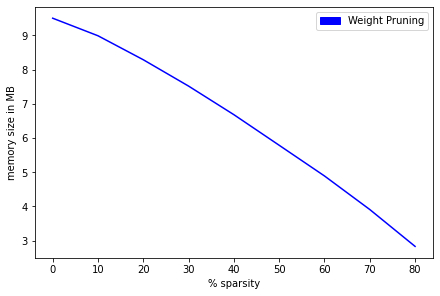

In [ ]:
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('memory size in MB')

blue_patch = mpatches.Patch(color='blue',label='Weight Pruning')
plt.legend(handles=[blue_patch],loc='upper right')
plt.plot([0,10,20,30,40,50,60,70,80],memory,color='blue')
plt.show()